# <div style="color:white;background-color:#1d1545;padding:5%;font-size:1.3em;text-align:center;text-shadow:2px 2px 4px black"> Feature Wizard in Action </div>

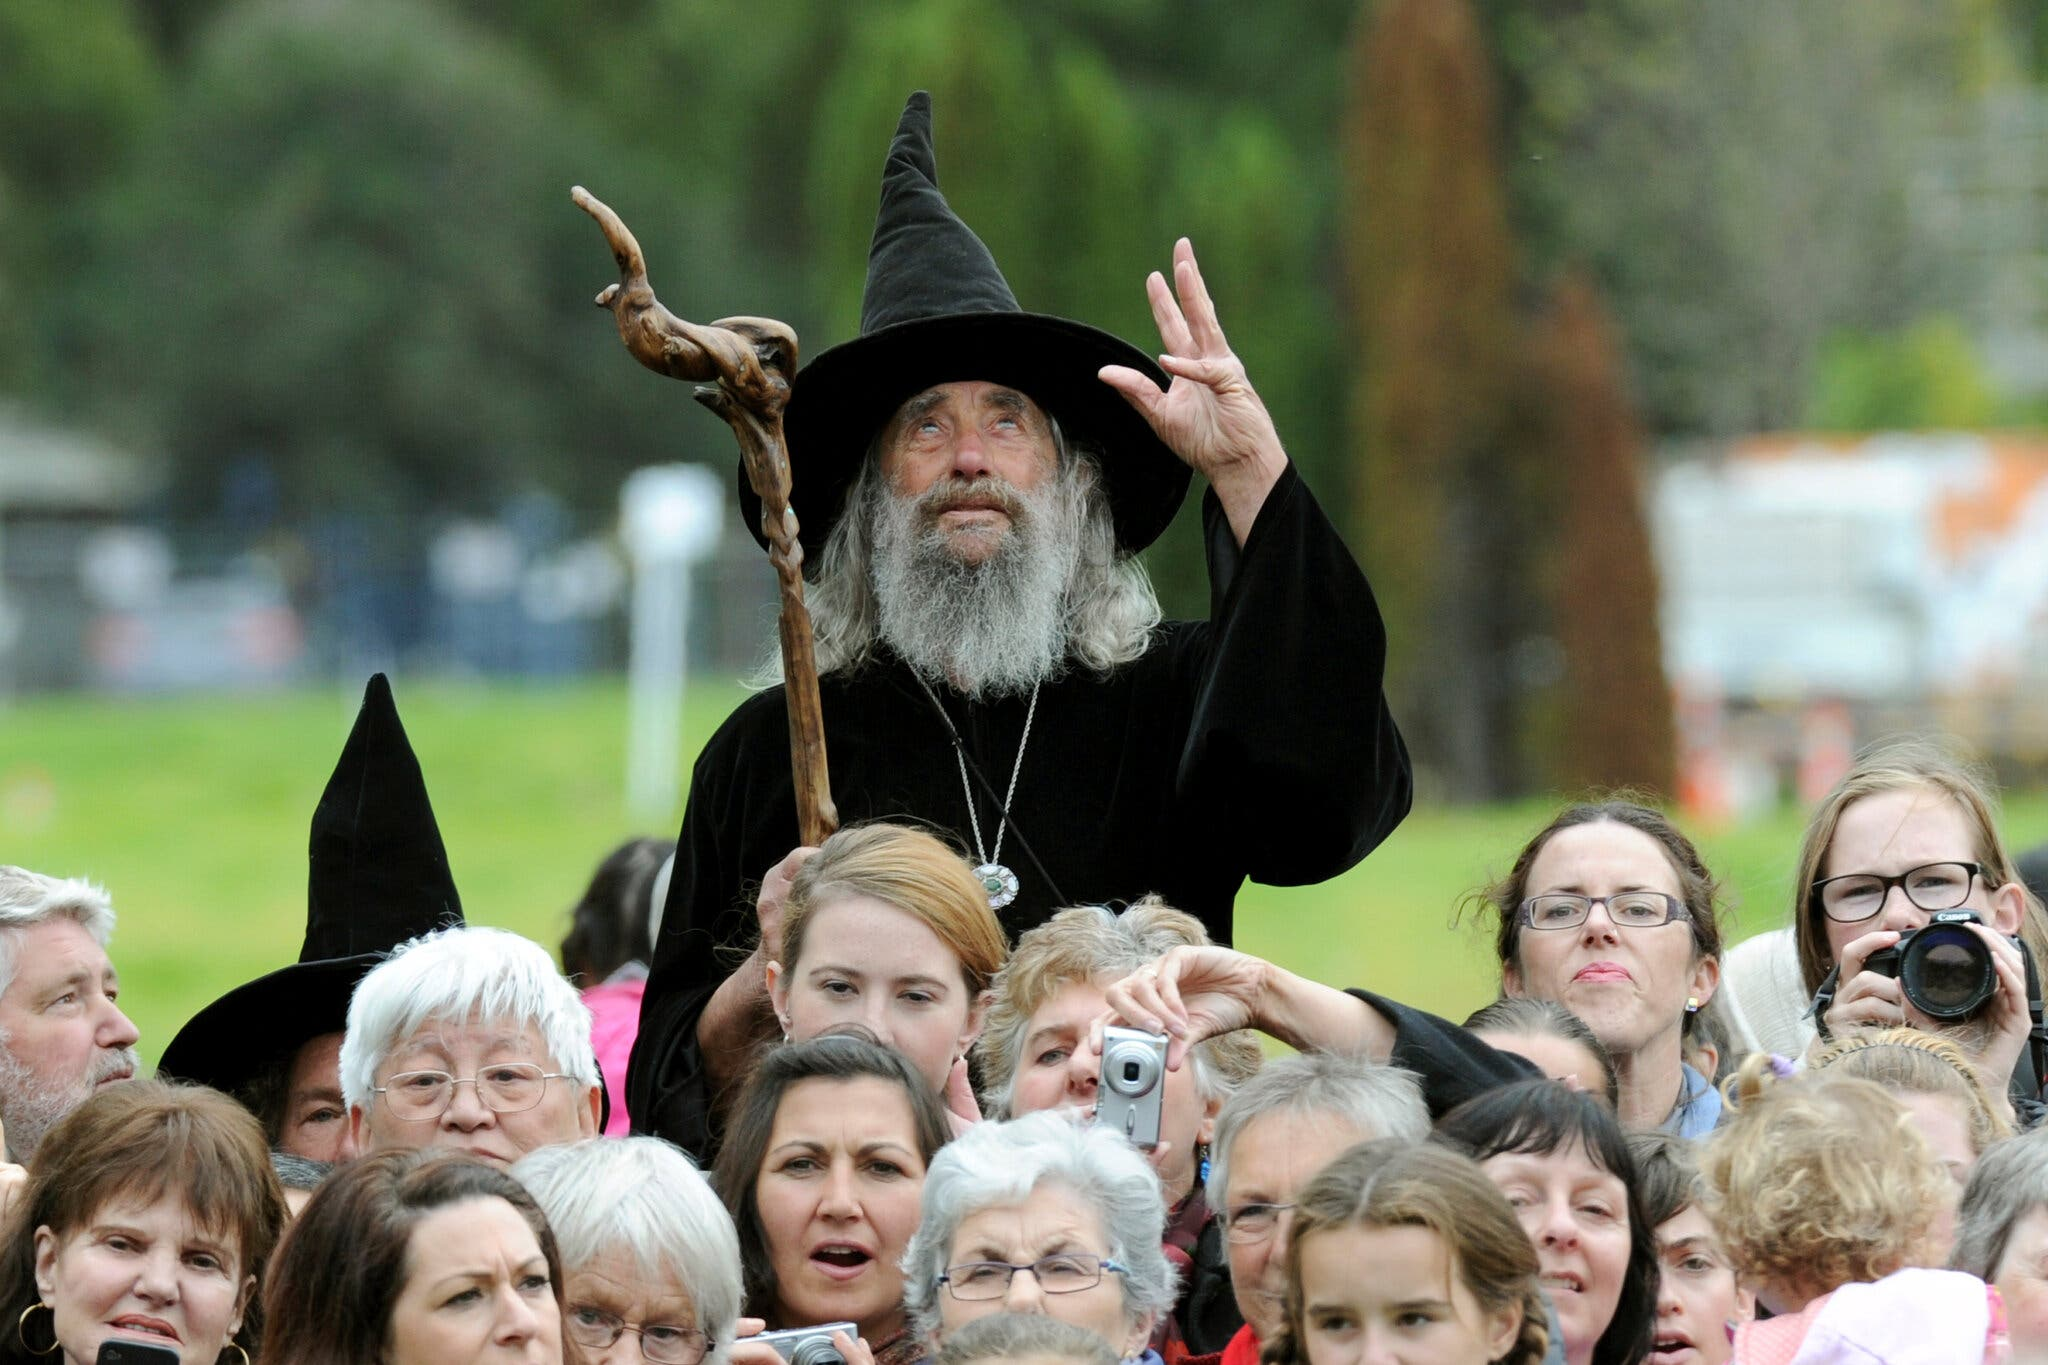

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Introduction</div>

This notebook is dedicated to detecting the feature importance for this contest with *FeatureWiz*. *FeatureWiz* will leverage its power to effectively select the subset of decisive features to properly interact with the target variable in a matter of minutes.

While doing the feature importance case study, we are going to take the inspiration/insights from @ambrosm who contributed with

- the nice EDA for this dataset conveyed per https://www.kaggle.com/ambrosm/tpsjan22-01-eda-which-makes-sense
- the feature engineering routines invented per https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model


# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Understanding FeatureWiz</div>

Featurewiz is an open-source python library that is an efficient and fast way to find out important variables from a dataset with respect to the target variable. It works on two different techniques which collectively helps in finding out the best features. These techniques are 

- SULOV
- recuirsive XGBoost training

The subsections below will explain these techniques in more details.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">SULOV</div>

Searching for the uncorrelated list of variables, this method finds out the pair of variables that are crossing a correlation threshold externally passed and thus are called highly correlated. After finding the pairs it calculates their MIS(Mutual Information Score) which is a quantity that measures the amount of information one can obtain from one random variable given another.

After that, it takes into consideration the pair of variables that have the least correlation and highest MIS scores. Which are further processed.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Recursive XGBoost</div>

The variables selected from SULOV are recursively passed through XGboost which helps in determining the best features according to the target variable bypassing the data into smaller datasets that are generated from the whole dataset.

In such a mannner, it selects the best feature variables from the dataset and that too in few lines of code only.


# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Installation of FeatureWiz</div>

*FeatureWiz* is not the part of the standard Python packages set enabled in the Docker container used by Kaggle notebooks. Therefore we will have to install it into the notebook interactively.

**Note:** Due to the the recuorsive dependencies loop in the recent pip versions, we are going to specifically install some important dependencies manually.

In [ ]:
!pip install scikit-learn==1.0.2

In [ ]:
!pip install xlrd --ignore-installed --no-deps

In [ ]:
!pip install featurewiz --ignore-installed --no-deps

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Running Feature Selection Experiment</div>

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import itertools
import gc
import math
from typing import Tuple, List, Dict
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
import dateutil.easter as easter


In [ ]:
import featurewiz as FW
import xgboost

In [ ]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

In [ ]:
%%time
# read data
in_kaggle = True

def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/tabular-playground-series-jan-2022/train.csv'
        test_path = '../input/tabular-playground-series-jan-2022/test.csv'
        sample_submission_path = '../input/tabular-playground-series-jan-2022/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/train.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path

# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

original_train_df = pd.read_csv(train_set_path)
original_test_df = pd.read_csv(test_set_path)
subm = pd.read_csv(sample_subm_path)
print(original_train_df.shape, original_test_df.shape)


In [ ]:
original_train_df.head()

In [ ]:
original_test_df.head()

In [ ]:
%%time
def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

In [ ]:
%%time
# The dates are read as strings and must be converted
for df in [original_train_df, original_test_df]:
    df['date'] = pd.to_datetime(df.date)
    df.set_index('date', inplace=True, drop=False)

In [ ]:
%%time
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""
    new_df = pd.DataFrame({'year': df.date.dt.year, # This feature makes it possible to fit an annual growth rate
                           'dayofyear': df.date.dt.dayofyear,
                           'wd4': df.date.dt.weekday == 4, # Friday
                           'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
                           'dec29': (df.date.dt.month == 12) & (df.date.dt.day == 29), # end-of-year peak
                           'dec30': (df.date.dt.month == 12) & (df.date.dt.day == 30),
                          })

    # Easter
    new_df['easter_week'] = False
    for year in range(2015, 2020):
        easter_date = easter.easter(year)
        easter_diff = df.date - np.datetime64(easter_date)
        new_df['easter_week'] = new_df['easter_week'] | (easter_diff > np.timedelta64(0, "D")) & (easter_diff < np.timedelta64(8, "D"))
    
    # Growth is country-specific
    #for country in ['Finland', 'Norway', 'Sweden']:
    #    new_df[f"{country}_year"] = (df.country == country) * df.date.dt.year
        
    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Sticker']:
        new_df[product] = df['product'] == product
        
    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 100): # 100
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'sticker_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Sticker']
        new_df[f'sticker_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Sticker']

    return new_df

train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer(original_test_df)
test_df.year = 2018 # no growth patch, see https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298318

test_df['date'] = original_test_df.date
test_df['num_sold'] = 0 # An artificial step 

features = test_df.columns

for df in [train_df, test_df]:
    df[features] = df[features].astype(np.float32)


In [ ]:
%%time
target = 'num_sold'
train_best, test_best = FW.featurewiz(train_df, target, corr_limit=0.70, verbose=2, sep=',', 
        header=0, test_data=test_df,feature_engg='', category_encoders='', dask_xgboost_flag=True, nrows=train_df.shape[0])


As we can see, the 'magic of FeatureWiz' resulted in

- dropping the highly correlated features ('dayofyear', 'sin1', 'cos1', 'sin12', 'date_is_festive', 'date_is_warm', 'date_year', 'date_dayofyear', 'date_weekofyear') from the original list of 608 features we engineered for our dataset with SULOV
- identifying the subset of 198 important features (out of 696 features remained after the SULOV probes stage)

Now we are going to review the list of features suggested to be important by *FeatureWiz*.

In [ ]:
print(test_best.columns.tolist())

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">FeatureWiz Takeaways</div>

*FeatureWiz* was designed for selecting High Performance variables with the fewest steps.

In most cases, *FeatureWiz* builds models with 20%-99% fewer features than your original data set with nearly the same or slightly lower performance.

In essence, you can thing of *FeatureWiz* to be a feature wizard that will:

- **Automatically pre-process data**: you can send in your entire dataframe "as is" and featurewiz will classify and change/label encode categorical variables changes to help XGBoost processing. It classifies variables as numeric or categorical or NLP or date-time variables automatically so it can use them correctly to model.
- **Perform feature engineering automatically**: The ability to create "interaction" variables or adding "group-by" features or "target-encoding" categorical variables is difficult and sifting through those hundreds of new features is painstaking and left only to "experts". Now, with featurewiz you can create hundreds or even thousands of new features with the click of a mouse. This is very helpful when you have a small number of features to start with. However, be careful with this option. You can very easily create a monster with this option.
- **Perform feature reduction automatically**. When you have small data sets and you know your domain well, it is easy to perhaps do EDA and identify which variables are important. But when you have a very large data set with hundreds if not thousands of variables, selecting the best features from your model can mean the difference between a bloated and highly complex model or a simple model with the fewest and most information-rich features. *FeatureWiz* uses XGBoost repeatedly to perform feature selection. You must try it on your large data sets and compare!
- **Explain SULOV method graphically** using networkx library so you can see which variables are highly correlated to which ones and which of those have high or low mutual information scores automatically. Just set verbose = 2 to see the graph.
- **Build a fast LightGBM model** using the features selected by featurewiz. There is a function called "simple_lightgbm_model" which you can use to build a fast model (note that the latter capability has been demonstrated in this notebook)

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">What Does Make FeatureWiz to Be Really Fast and Efficient?</div>

If you review the source code of the latest version of *FeatureWiz*, you will see a lot of features to optimize the product for the speed of processing your data while still focusing on the high accuracy / relevance of the feature importance scores. These are

- using dask for parallel processing the dataframes (especially powerful on large datasets where pandas hits its limits)
- using a number of memory optimization techniques
- reusing a bunch of AutoML innovations delivered by Alex Lekov (https://github.com/Alex-Lekov/AutoML_Alex/tree/master/automl_alex) - that is, DataBunch and encoders modules which are used by the tool (although with some modifications).
- using Category Encoders library in Python (https://contrib.scikit-learn.org/category_encoders/index.html)

Speed of processing, combined with the relevance of the feature importance scores calculated, makes *FeatureWiz* a unique tool in the industrial setup where the time to market with the discoveries is as important as the relevance of the findings/insights you as a Data Scientist come up with.

**Note:** Someone could claim the size of the dataset for this competition is not that big, and therefore the *FeatureWiz*'s speed of processing (doing the feature importance scoring in less then 5 min) is not indicative. In such a case, I would like to mention my benchmarking for a way bigger dataset for Dec 2021 TPC. For that dataset, the feature importance calculations facilitated by *FeatureWiz* took about 22 min whereas the alternative feature importance  experiment (permutative feature importance with ELI5, per https://www.kaggle.com/gvyshnya/eli5-perm-fi-with-additional-fe-dec-21-tpc) took about 3.5 h to go through.

In [ ]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">References</div>


- Github repo of FeatureWiz: https://github.com/AutoViML/featurewiz
- the nice EDA for this dataset conveyed per https://www.kaggle.com/ambrosm/tpsjan22-01-eda-which-makes-sense
- the feature engineering routines invented per https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model
- the cover image reused from https://www.nytimes.com/2021/10/18/world/australia/christchurch-new-zealand-wizard.html